In [3]:
import h5py
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

D =  0.8412907524741113 ± 0.020521850461916822
nu =  0.7473373895736047 ± 0.0018410780847226867


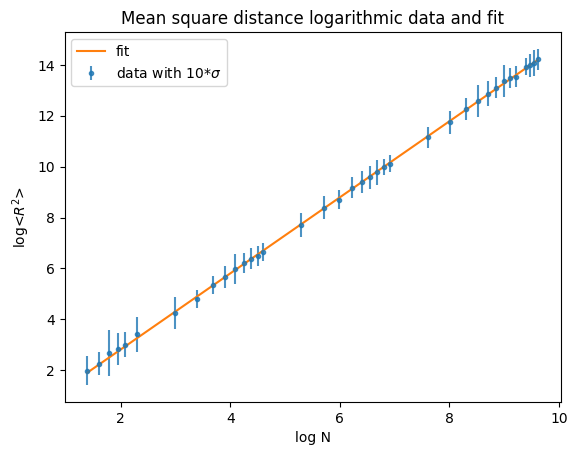

In [87]:
## initial fit

def batch_estimate(data,observable,k):
    batches = np.reshape(data,(k,-1))
    values = np.apply_along_axis(observable, 1, batches)
    return np.mean(values), np.std(values)/np.sqrt(k-1)

def fit_log_square_distance(N, D, nu):
    return np.log(D) + 2*nu*np.log(N)

walk_length = np.arange(2,10, step=1, dtype=int)
walk_length = np.concatenate((walk_length, np.arange(10, 100, step=10, dtype=int)))
walk_length = np.concatenate((walk_length, np.arange(100, 1000, step=100, dtype=int)))
walk_length = np.concatenate((walk_length, np.arange(1000, 11000, step=1000, dtype=int)))
walk_length = np.concatenate((walk_length, np.arange(12000, 16000, step=1000, dtype=int)))

num_batches = 10
dist_means, dist_errors = [], []

#read the data
for N in walk_length:
    file = 'Final_SAW_data_250/data_n_{}_m_250_s_0.1.hdf5'.format(N)
    with h5py.File(file, 'r') as f:
        distances = f['end-to-end-distances'][:,1]
        mean, err = batch_estimate(distances**2,lambda x:np.mean(x),num_batches)
        dist_means.append(mean)
        dist_errors.append(err)

log_mean_square_distances = np.log(dist_means) 
std_log_distances = np.asarray(dist_errors)/np.asarray(dist_means)

#fit linear equation
estimates, errors = sp.optimize.curve_fit(fit_log_square_distance, walk_length, log_mean_square_distances, sigma=std_log_distances)
D_fit, nu_fit = estimates[0], estimates[1]
D_err, nu_err = np.sqrt(errors[0,0]), np.sqrt(errors[1,1])

#plot
plt.errorbar(np.log(walk_length), log_mean_square_distances, yerr=std_log_distances*10, fmt='.', alpha=0.8, label=r'data with 10*$\sigma$')
#plt.errorbar(walk_length, dist_means, yerr=dist_errors, fmt='.')
#plt.plot(walk_length, np.sqrt(D_fit)*walk_length**(nu_fit))
plt.plot(np.log(walk_length), np.log(D_fit) + 2*nu_fit*np.log(walk_length), label="fit")
plt.xlabel("log N")
plt.ylabel(r"log<$R^2$>")
plt.title("Mean square distance logarithmic data and fit")
plt.legend()

#results
print("D = ", D_fit, u"\u00B1", D_err)
print("nu = ", nu_fit, u"\u00B1", nu_err)

(0.72, 0.77)

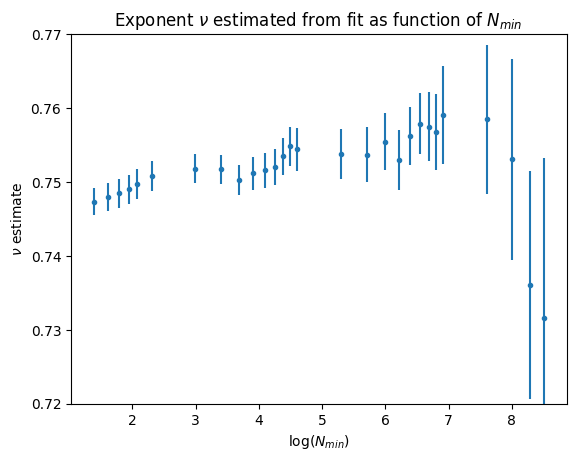

In [89]:
## fit as function of cutoff for N

N_min = walk_length[:-9]  #we demand at least 10 data points to make the fit
nu_fits, nu_errors = [], []

#fit
for i in range(len(N_min)):
    estimates, errors = sp.optimize.curve_fit(fit_log_square_distance, walk_length[i:], log_mean_square_distances[i:], sigma=std_log_distances[i:])
    nu_fits.append(estimates[1])
    nu_errors.append(np.sqrt(errors[1,1]))
    d_expected = fit_log_square_distance(walk_length[i:], estimates[0], estimates[1])

#plot
plt.errorbar(np.log(N_min), nu_fits, yerr=nu_errors, fmt='.')
plt.xlabel(r'log($N_{min}$)')
plt.ylabel(r"$\nu$ estimate")
plt.title(r"Exponent $\nu$ estimated from fit as function of $N_{min}$ ")
plt.ylim(0.72,0.77)

Text(0.5, 1.0, 'Exponent $\\nu$ estimated from fit in batches')

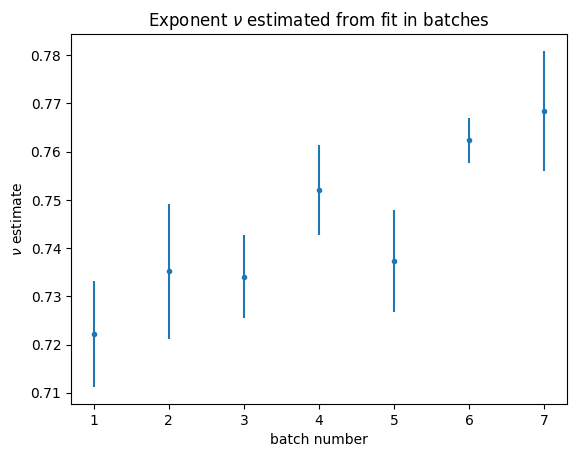

In [91]:
##fit in batches

nu_fits, nu_errors = [], []
batches = 9
n_batch = 10

#fit
for i in range(batches-2):
    i,j = int(i*(36/batches)), int(i*(36/batches)+n_batch)
    estimates, errors = sp.optimize.curve_fit(fit_log_square_distance, walk_length[i:j], log_mean_square_distances[i:j], sigma=std_log_distances[i:j])
    nu_fits.append(estimates[1])
    nu_errors.append(np.sqrt(errors[1,1]))

#plot
plt.errorbar(np.arange(batches-2)+1, nu_fits, yerr=nu_errors, fmt='.')
plt.xlabel(r'batch number')
plt.ylabel(r"$\nu$ estimate")
plt.title(r"Exponent $\nu$ estimated from fit in batches")

D =  0.8025050598404411 ± 0.00799822316840164
b =  0.7496941155666731 ± 0.9457822084703115
Delta =  1.159246177385394 ± 0.7640061912968198


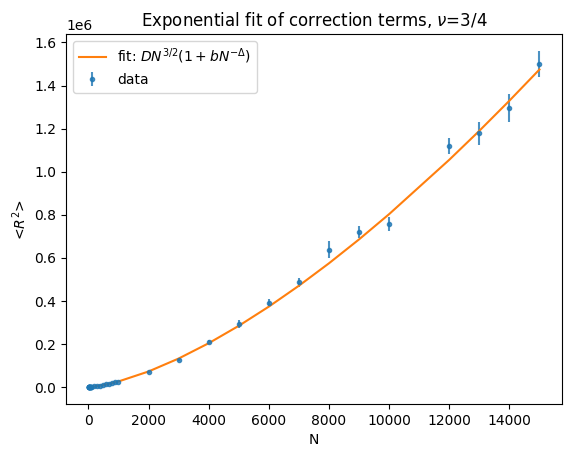

In [92]:
def fit_distance_corr(N, D, b, delta):
    return D*N**(3/2)*(1+b*N**(-delta))

#fit
estimates, errors = sp.optimize.curve_fit(fit_distance_corr, walk_length, dist_means, sigma=dist_errors)
D_fit, b_fit, delta_fit = estimates[0], estimates[1], estimates[2]
D_err, b_err, delta_err = np.sqrt(errors[0,0]), np.sqrt(errors[1,1]), np.sqrt(errors[2,2])

#plot
plt.errorbar(walk_length, dist_means, yerr=dist_errors, fmt='.', alpha=0.8, label=r'data')
#plt.errorbar(walk_length, dist_means, yerr=dist_errors, fmt='.')
#plt.plot(walk_length, np.sqrt(D_fit)*walk_length**(nu_fit))
plt.plot(walk_length, fit_distance_corr(walk_length, D_fit, b_fit, delta_fit), label=r"fit: $DN^{3/2}(1+bN^{-\Delta})$")
plt.xlabel("N")
plt.ylabel(r"<$R^2$>")
plt.title(r"Exponential fit of correction terms, $\nu$=3/4")
plt.legend()


#print results
print("D = ", D_fit, u"\u00B1", D_err)
print("b = ", b_fit, u"\u00B1", b_err)
print("Delta = ", delta_fit, u"\u00B1", delta_err)

D =  0.7976908709336512 ± 0.02859172477108183
nu =  0.7510403454939343 ± 0.00239944593475686


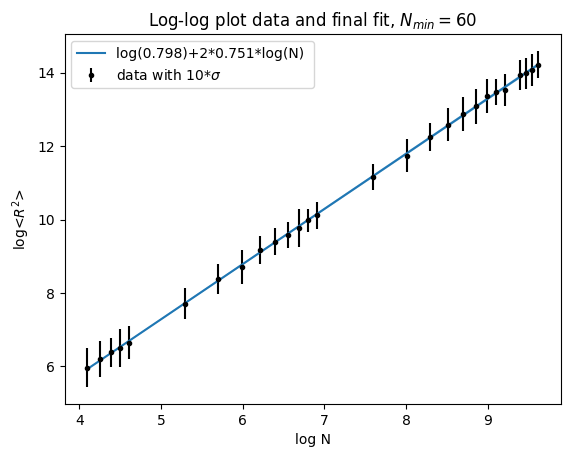

In [85]:
##final fit with cutoff

cutoff = 10 #corresponds to N_min=60

#fit
estimates, errors = sp.optimize.curve_fit(fit_log_square_distance, walk_length[cutoff:], log_mean_square_distances[cutoff:], sigma=std_log_distances[cutoff:])
D_fit, nu_fit = estimates[0], estimates[1]
D_err, nu_err = np.sqrt(errors[0,0]), np.sqrt(errors[1,1])

#plot
plt.errorbar(np.log(walk_length[cutoff:]), log_mean_square_distances[cutoff:], yerr=10*std_log_distances[cutoff:], fmt='.', color='black', label=r"data with 10*$\sigma$")
plt.fill_between(np.log(walk_length[cutoff:]),fit_log_square_distance(walk_length[cutoff:], D_fit, nu_fit+nu_err),fit_log_square_distance(walk_length[cutoff:], D_fit, nu_fit-nu_err), alpha=0.4)
plt.plot(np.log(walk_length[cutoff:]), fit_log_square_distance(walk_length[cutoff:], D_fit, nu_fit) , label="log({:.3f})+2*{:.3f}*log(N) ".format(D_fit, nu_fit), color='tab:blue')
plt.xlabel("log N")
plt.ylabel(r"log<$R^2$>")
plt.legend()
plt.title(r"Log-log plot data and final fit, $N_{min}=60$")

#print results
print("D = ", D_fit, u"\u00B1", D_err)
print("nu = ", nu_fit, u"\u00B1", nu_err)